In [8]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)
    
learning_rate = 0.001
epochs = 10
batch_size=8

In [10]:
trans = transforms.ToTensor()

# temp
train_set = torchvision.datasets.ImageFolder('data/train',transform=trans)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = torchvision.datasets.ImageFolder('data/valid',transform=trans)
test_loader = DataLoader(test_set)

In [11]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # our image size:
        # 3 * 384 * 512
        # rgb * H * W
        
        # 32 channels of 192*256
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        
        # 64 channels of 96*128
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        
        # 64*96*128 => 6 classes
        self.fc = torch.nn.Linear(64*96*128, 6)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [12]:
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(train_loader)

In [13]:
for epoch in range(epochs):
    avg_cost = 0
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(x)
        cost = criterion(hypothesis, y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
        
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 2.69628596
[Epoch:    2] cost = 1.39120376
[Epoch:    3] cost = 1.13084173
[Epoch:    4] cost = 0.827408254
[Epoch:    5] cost = 0.573861659
[Epoch:    6] cost = 0.35154286
[Epoch:    7] cost = 0.203047499
[Epoch:    8] cost = 0.190155596
[Epoch:    9] cost = 0.161094576
[Epoch:   10] cost = 0.0992395431


accuracy: 0.4420731707317073
wrong ans: metal , correct ans: trash


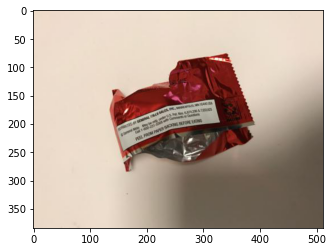

In [14]:
num_correct = 0
to_img_trans = transforms.ToPILImage()
for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    
    prediction = torch.argmax(model(x), 1)
    if prediction == y:
        num_correct += 1
    else:
        # print(test_set.classes[prediction], test_set.classes[y])
        wrong_x, wrong_ans, ans = x, test_set.classes[prediction], test_set.classes[y]

accuracy = num_correct / len(test_loader)
print('accuracy:',accuracy)

img = to_img_trans(torch.tensor(wrong_x.cpu().detach().numpy().reshape(3,384,512)))
plt.imshow(img)
print('wrong ans:', wrong_ans, ',','correct ans:', ans)